In [1]:
import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn

from utills import plot_admm_vs_ladmm_reconstruction
from utills import create_data_set, plot_admm_vs_ladmm_convergence

torch.manual_seed(0)

torch.set_default_dtype(torch.float64)

The following createss a sparse signals databases. each database comprised of N signal matrix with each signal
is 200x1 vector which is k-sparse signal

In [2]:
n, m, k = 150, 200, 4

# Measurement matrix
H = torch.randn(n, m)
H /= torch.norm(H, dim=0)

train_loader = create_data_set(H, n=n, m=m, k=k, N=1000)

test_loader = create_data_set(H, n=n, m=m, k=k, N=1000)

Vanilla ADMM implementation

In [3]:
def vanilla_admm(x, H, lambda_=12.5, mu=0.00005, rho=0.01, max_itr=300, eps=10 ** -5):
    proj = torch.nn.Softshrink(rho / (2 * lambda_))

    # initial estimate
    s = torch.zeros((H.shape[1]))
    u = torch.zeros((H.shape[1]))
    v = torch.zeros((H.shape[1]))

    # left_term = (H^TH+2λI)^-1 2*lambda or rho?
    left_term = torch.linalg.inv(H.T @ H + rho * torch.eye(H.shape[1]))

    recovery_errors = []
    for k in range(max_itr):
        s_prev, v_prev, u_prev = s, v, u

        # Update s_k+1 = ((H^T)H+2λI)^−1(H^T x+2λ(vk−uk)).

        right_term = H.T @ x + rho * (v_prev - u_prev)
        s = left_term @ right_term

        # Update vk+1 = prox_(1/2λϕ)(sk+1 + uk)
        v = proj(s + u_prev)

        # Update uk+1 = uk + μ (sk+1 − vk+1).

        u = u_prev + mu * (s - v)

        # # cease if convergence achieved
        if torch.sum(torch.abs(s - s_prev)) <= eps:
            break

        # save recovery error
        recovery_errors.append(torch.sum((torch.matmul(H, s) - x) ** 2))

    return s

Model Based ADMM implementation

In [4]:
class LADMM_Model(nn.Module):
    def __init__(self, n, m, T=6, rho=0.01, H=None, lambda_=12.5, mu=0.00005):
        super(LADMM_Model, self).__init__()
        self.n, self.m = n, m
        self.H = H

        # ISTA Iterations
        self.T = T

        # Initialization
        self.rho = nn.Parameter(torch.ones(T + 1, 1, 1) * rho, requires_grad=True) # Lagrangian Multiplier
        self.lambda_ = nn.Parameter(torch.ones(T + 1, 1, 1) * lambda_, requires_grad=True)
        self.mu = nn.Parameter(torch.ones(T + 1, 1, 1) * mu, requires_grad=True)

    def _shrink(self, s, beta, rho):
        return beta * F.softshrink(s / beta, lambd=rho)

    def forward(self, x):
        """

        Args:
            x: a sparse signal observation
        Returns: S reconstruction
        """
        # H.shape[1] = 200, x.shape[0[ = 512 (batch size)
        # s_prev = torch.zeros(x.shape[0], self.H.shape[1])
        u_prev = torch.zeros((x.shape[0], self.H.shape[1]))
        v_prev = torch.zeros((x.shape[0], self.H.shape[1]))

        #################### Iteration 0 ####################

        #TODO NIR left_term = (H^TH+2λI)^-1 2*lambda or rho?
        left_term = torch.linalg.inv(self.H.T @ self.H + self.rho[0, :, :] * torch.eye(self.H.shape[1]))

        right_term = (self.H.T @ x.T).T + self.rho[0, :, :] * (v_prev - u_prev)

        s = (left_term @ right_term.T).T
        v = self._shrink(s + u_prev,
                         self.rho[0, :, :] / (2 * self.lambda_[0, :, :]),
                         rho=self.rho[0, :, :].item())
        u = u_prev + self.mu[0, :, :] * (s - v)

        #################### Iteration 1<=i<=K ####################

        for i in range(1, self.T + 1):
            s_prev, v_prev, u_prev = s, v, u

            # left_term = (H^TH+2λI)^-1 2*lambda or rho?
            left_term = torch.linalg.inv(self.H.T @ self.H + self.rho[i, :, :] * torch.eye(self.H.shape[1]))

            right_term = (self.H.T @ x.T).T + self.rho[i, :, :] * (v_prev - u_prev)

            # Update s_k+1 = ((H^T)H+2λI)^−1(H^T x+2λ(vk−uk)).
            s = (left_term @ right_term.T).T

            # Update vk+1 = prox_(1/2λϕ)(sk+1 + uk)
            v = self._shrink(s + u_prev, self.rho[i, :, :] / (2 * self.lambda_[i, :, :]), rho=self.rho[i, :, :].item())

            # Update uk+1 = uk + μ (sk+1 − vk+1).
            u = u_prev + self.mu[i, :, :] * (s - v)

        return s

The function trains a machine learning model

In [5]:
def train(model, train_loader, valid_loader, num_epochs=60):
    """Train a network.
    Returns:
        loss_test {numpy} -- loss function values on test set
    """
    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(train_loader):
            s_hat = model(b_x)
            loss = F.mse_loss(s_hat, b_s, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()

        # Aggregate loss
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(valid_loader):
            s_hat = model(b_x)
            test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        if epoch % 10 == 0:
            print("Epoch %d, Train loss %.8f, Validation loss %.8f" % (epoch, loss_train[epoch], loss_test[epoch]))

    return loss_test, b_x, b_s

The apply function perform L-ADMM or ADMM upon the whole sparse signal database and aggregate the loss.

In [6]:
def ladmm_apply(train_loader, test_loader, T, H):
    n = H.shape[1]
    m = H.shape[1]

    ladmm = LADMM_Model(n=n, m=m, T=T, H=H)

    loss_test, b_x, b_s = train(ladmm, train_loader, test_loader)
    err_list = loss_test[-1]

    return err_list, ladmm, b_x, b_s


def admm_apply(test_loader, T, H):

    loss = 0

    for step, (x, _, s) in enumerate(test_loader.dataset):
        s_hat = vanilla_admm(x=x, H=H, max_itr=T)
        loss += F.mse_loss(s_hat, s, reduction="sum").data.item()

    return loss / len(test_loader.dataset)

Epoch 0, Train loss 0.28706699, Validation loss 0.28922873
Epoch 10, Train loss 0.28645093, Validation loss 0.28885162
Epoch 20, Train loss 0.28629877, Validation loss 0.28879813
Epoch 30, Train loss 0.28628932, Validation loss 0.28880622
Epoch 40, Train loss 0.28629125, Validation loss 0.28879186
Epoch 50, Train loss 0.28629034, Validation loss 0.28879014


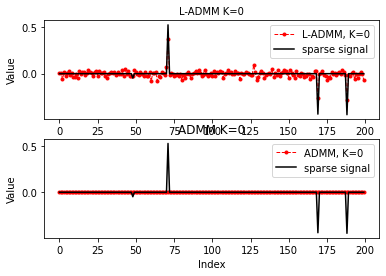

Epoch 0, Train loss 0.29374352, Validation loss 0.29609212
Epoch 10, Train loss 0.27682243, Validation loss 0.27766850
Epoch 20, Train loss 0.23009541, Validation loss 0.22671858
Epoch 30, Train loss 0.12190523, Validation loss 0.11843540
Epoch 40, Train loss 0.07192596, Validation loss 0.07309221
Epoch 50, Train loss 0.05765103, Validation loss 0.06002318


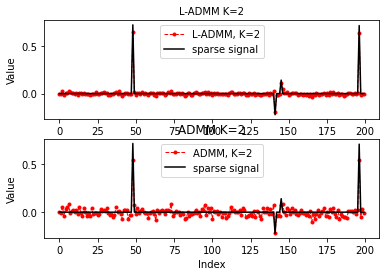

Epoch 0, Train loss 0.29395161, Validation loss 0.29641284
Epoch 10, Train loss 0.29284408, Validation loss 0.29498957
Epoch 20, Train loss 0.27257366, Validation loss 0.27137052
Epoch 30, Train loss 0.17673894, Validation loss 0.16912501
Epoch 40, Train loss 0.05766666, Validation loss 0.05628592
Epoch 50, Train loss 0.03056298, Validation loss 0.03246686


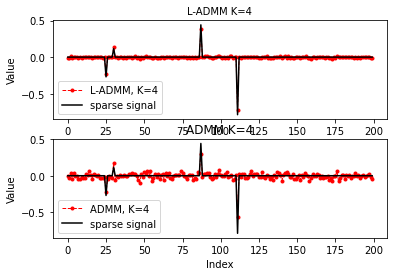

Epoch 0, Train loss 0.29390471, Validation loss 0.29636662
Epoch 10, Train loss 0.29321691, Validation loss 0.29554482
Epoch 20, Train loss 0.28607590, Validation loss 0.28704846
Epoch 30, Train loss 0.22666836, Validation loss 0.22021886
Epoch 40, Train loss 0.07570609, Validation loss 0.07034124
Epoch 50, Train loss 0.02257892, Validation loss 0.02426875


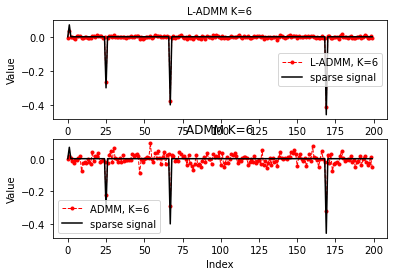

Epoch 0, Train loss 0.29384705, Validation loss 0.29630754
Epoch 10, Train loss 0.29299371, Validation loss 0.29529704
Epoch 20, Train loss 0.28584360, Validation loss 0.28698793
Epoch 30, Train loss 0.23181376, Validation loss 0.22575005
Epoch 40, Train loss 0.07635639, Validation loss 0.06992193
Epoch 50, Train loss 0.01811507, Validation loss 0.01954293


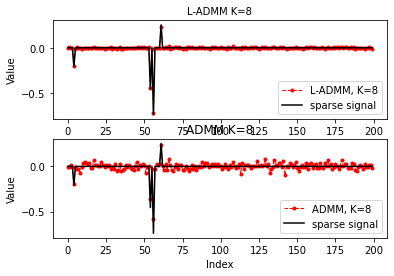

Epoch 0, Train loss 0.29378887, Validation loss 0.29624774
Epoch 10, Train loss 0.29273564, Validation loss 0.29500227
Epoch 20, Train loss 0.28438188, Validation loss 0.28537578
Epoch 30, Train loss 0.22777566, Validation loss 0.22148139
Epoch 40, Train loss 0.07170271, Validation loss 0.06534414
Epoch 50, Train loss 0.01577706, Validation loss 0.01696922


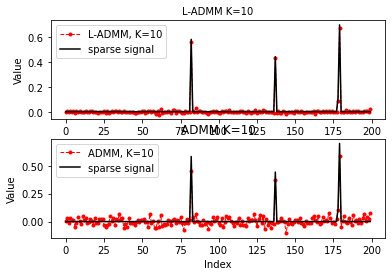

Epoch 0, Train loss 0.29373066, Validation loss 0.29618792
Epoch 10, Train loss 0.29247263, Validation loss 0.29470114
Epoch 20, Train loss 0.28271490, Validation loss 0.28349807
Epoch 30, Train loss 0.22144817, Validation loss 0.21499863
Epoch 40, Train loss 0.06709761, Validation loss 0.06099083
Epoch 50, Train loss 0.01468286, Validation loss 0.01569848


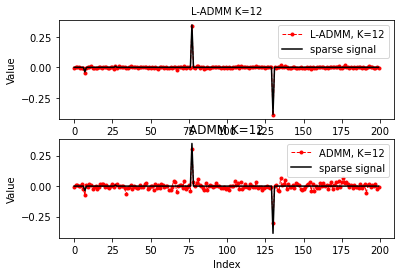

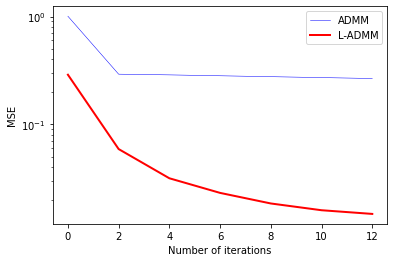

In [7]:

# Number of unfoldings
tstart, tend, tstep = 0, 13, 2
T_opt = range(tstart, tend, tstep)

admm_mse = []
ladmm_mse = []

for i, T in enumerate(T_opt):

    # Train and apply model based ADMM
    err_lst, k_l_admm, b_x, b_s = ladmm_apply(train_loader, test_loader, T, H)
    ladmm_mse.append(err_lst)

    # Apply vanilla ADMM
    admm_mse.append(admm_apply(test_loader, T, H))

    ######################### Visualization #########################

    # Visualize performance of a single signal from the validation batches b_x, b_s
    b_x, s_gt = b_x[0], b_s[0]

    s_hat_ladmm = k_l_admm(b_x)
    s_hat_ladmm = s_hat_ladmm.detach().numpy()[0]

    s_hat_admm = vanilla_admm(x=b_x, H=H, max_itr=T)

    plot_admm_vs_ladmm_reconstruction(s_hat_admm=s_hat_admm,
                                      s_hat_ladmm=s_hat_ladmm, T=k_l_admm.T, s_gt=s_gt)


plot_admm_vs_ladmm_convergence(T_opt,admm_mse, ladmm_mse)

